<a href="https://colab.research.google.com/github/ggruszczynski/gpu_colab/blob/main/70_heat_diffusion2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numba import cuda
from numba import jit
import numpy as np
# from numba import vectorize, int32, int64, float32, float64
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!nvidia-smi

Mon Mar 11 10:33:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Note the use of an `out` array. CUDA kernels written with `@cuda.jit` do not return values,
# just like their C counterparts. Also, no explicit type signature is required with @cuda.jit
@cuda.jit
def add_kernel(x, y, out):

    # The actual values of the following CUDA-provided variables for thread and block indices,
    # like function parameters, are not known until the kernel is launched.

    # This calculation gives a unique thread index within the entire grid (see the slides above for more)
    idx = cuda.grid(1)          # 1 = one dimensional thread grid, returns a single value.
                                # This Numba-provided convenience function is equivalent to
                                # `cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x`

    # This thread will do the work on the data element with the same index as its own
    # unique index within the grid.
    out[idx] = x[idx] + y[idx]

In [4]:
n = 2**15 # ~0.1MB
# n = 2**28 # ~1GB
x = np.arange(n).astype(np.float32) # [0...4095] on the host, for n = 2**11
y = 1000* np.ones_like(x)               # [1...1] on the host
print(f"Number of elements: {n} \nMemory size of x array in [MB]: {x.nbytes/1E6}")


d_x = cuda.to_device(x) # Copy of x on the device
d_y = cuda.to_device(y) # Copy of y on the device
d_out = cuda.device_array_like(d_x) # Like np.array_like, but for device arrays

# Because of how we wrote the kernel above, we need to have a 1 thread to one data element mapping,
# therefore we define the number of threads in the grid (128*32) to equal n (4096).
threads_per_block = 128
blocks_per_grid = 32

Number of elements: 32768 
Memory size of x array in [MB]: 0.131072


In [5]:
np.set_printoptions(precision=2)
y

array([1000., 1000., 1000., ..., 1000., 1000., 1000.], dtype=float32)

In [6]:
add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)
cuda.synchronize()
print(d_out.copy_to_host())

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[1000. 1001. 1002. ...    0.    0.    0.]


In [7]:
from numba import vectorize

@vectorize(['float32(float32, float32)'], target='cuda') # Type signature and target are required for the GPU
def add_ufunc(x, y):
    return x + y


## Let us run some benchmarks


In [8]:
%timeit -r 7 -n 5000 np.add(x, y)   # NumPy on CPU

6.93 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [9]:
%timeit -r 7 -n 5000 add_ufunc(x, y) # Numba on GPU

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


1.07 ms ± 56.6 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [10]:
%timeit -r 7 -n 5000 add_ufunc(d_x, d_y) # Numba on GPU - data fetched to gpu

377 µs ± 45.9 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [11]:
%timeit -r 7 -n 5000 add_kernel[blocks_per_grid, threads_per_block](x, y, d_out) # hand crafted kernel - data from cpu

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


964 µs ± 61.9 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


In [12]:
%timeit -r 7 -n 5000 add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out) # hand crafted kernel - data fetched to gpu

54.6 µs ± 1.29 µs per loop (mean ± std. dev. of 7 runs, 5000 loops each)


### Conclusions

Observe that the difference in the time of execution becomes significant (and infavour for GPU) only for large arrays.

Benchmark both scenarios:

`%timeit -r 7 -n 10` for large array, ~1GB.

`%timeit -r 7 -n 1000` for small array, ~1MB.

The number (-n) controls how many executions (aka loops) are done for each timing and it's used to get representative timings. The repeat  (-r) argument controls how many timings are done and its use is to get accurate statistics.

To get reasonable results, the average time per loop shall be > 10 µs.
More in [next](https://github.com/ggruszczynski/gpu_colab/blob/main/80_gpu_aos_vs_soa_mem_layout.ipynb) exercise.

## 2D-diffusion

The 2D-diffusion equation is known as

$$\frac{\partial u}{\partial t} = \nu \left(\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2} \right) $$

The same scheme as in the case of 1D diffusion problem will be adopted to account for spatial derivatives in both x and y direction.
It consinst of a forward difference in time and two second-order spatial derivatives.

$$\frac{u_{i,j}^{n+1} - u_{i,j}^n}{\Delta t} = \nu \frac{u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n}{\Delta x^2} + \nu \frac{u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n}{\Delta y^2}$$

Solving the discretized equation for $u_{i,j}^{n+1}$

$$
\begin{split}
u_{i,j}^{n+1} = u_{i,j}^n &+ \frac{\nu \Delta t}{\Delta x^2}(u_{i+1,j}^n - 2 u_{i,j}^n + u_{i-1,j}^n) \\
&+ \frac{\nu \Delta t}{\Delta y^2}(u_{i,j+1}^n-2 u_{i,j}^n + u_{i,j-1}^n)
\end{split}
$$

In [13]:

# @vectorize(['float32[:](int32, int32, float32, float32, float32)'], target='parallel')  #

@jit(nopython=True)
def step_cpu(nx, ny, fact, A_in,  A_out):
    # loop over all points in domain (except boundary)
    for x in range(1,nx-1):
        for y in range(1,ny-1):
            d2tdx2 = A_in[x-1][y] - 2*A_in[x][y] + A_in[x+1][y]
            d2tdy2 = A_in[x][y-1] - 2*A_in[x][y] + A_in[x][y+1]
            #update temperatures
            A_out[x][y] = A_in[x][y]+fact*(d2tdx2 + d2tdy2)

In [14]:
@cuda.jit
def step_kernel_gpu(nx, ny, fact, A_in,  A_out):
    x, y = cuda.grid(2)
    # The above is equivalent to the following 2 lines of code:
    # x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    # y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    # loop over all points in domain (except boundary)
    if (x > 0 and y > 0 and x < nx-1 and y < ny-1):
    # if (x < nx and y < ny):
        d2tdx2 = A_in[x-1][y] - 2*A_in[x][y] + A_in[x+1][y]
        d2tdy2 = A_in[x][y-1] - 2*A_in[x][y] + A_in[x][y+1]
        #update temperatures
        A_out[x][y] = A_in[x][y]+fact*(d2tdx2 + d2tdy2)

In [15]:
diffusivity = 1e-2 # thermal diffusivity
nstep = int(1e4)     # number of time steps
#Specify our 2D dimensions
nx = 512
ny = 512

In [16]:
threads_per_block = (32, 32) # 2D blocks, 32*32=1024 threads, this is the maximum number of threads in the block
blocks = (16, 16) #2D grid
assert threads_per_block[0]*blocks[0] == nx and threads_per_block[1]*blocks[1] == ny

a1 = np.ones((nx, ny)).astype(np.float32) #create a nx * ny vector of 1's
a2 = np.ones((nx, ny)).astype(np.float32)

###Assign initial conditions
a1[int(nx/4):int(3*nx/4), int(ny/4):int(3*ny/4)] = 2
# a2[int(nx/4):int(3*nx/4), int(ny/4):int(3*ny/4)] = 2

d_a1 = cuda.to_device(a1)
d_a2 = cuda.to_device(a2)

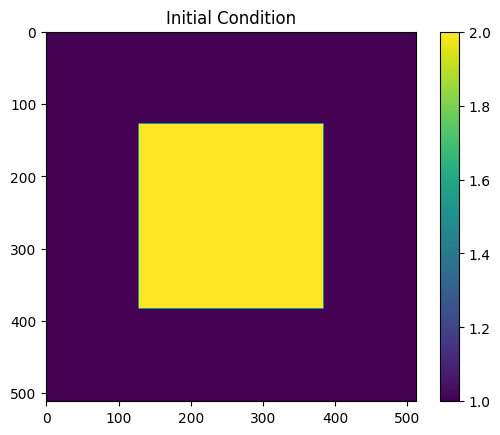

In [17]:
plt.imshow(d_a1.copy_to_host())
plt.colorbar()
plt.title('Initial Condition')
plt.show()

In [18]:
def iterate_cpu(a1, a2):
    for i in range(0,nstep):
        step_cpu(nx, ny, diffusivity, a1,  a2)
        # // swap the temperature pointers
        tmp = a1
        a1 = a2
        a2 = tmp


In [19]:
%timeit iterate_cpu(a1, a2)

2.37 s ± 144 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


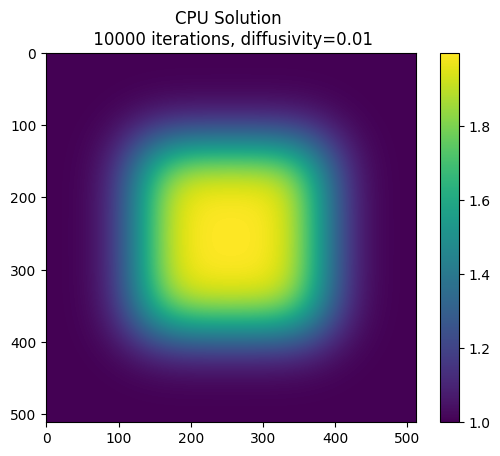

In [20]:
solution = a1

plt.imshow(solution)
plt.colorbar()
plt.title(f'CPU Solution \n {nstep} iterations, diffusivity={diffusivity}')
plt.show()

In [21]:
def iterate_gpu(d_a1,  d_a2):
    for i in range(0,nstep):
        step_kernel_gpu[blocks, threads_per_block](nx, ny, diffusivity, d_a1,  d_a2)
        cuda.synchronize()
        # // swap the temperature pointers
        tmp = d_a1
        d_a1 = d_a2
        d_a2 = tmp

In [22]:
%timeit iterate_gpu(d_a1,  d_a2)

1.26 s ± 117 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


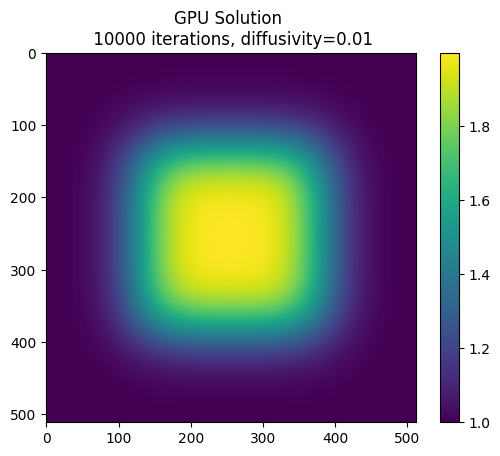

In [23]:
solution = d_a1.copy_to_host()

plt.imshow(solution)
plt.colorbar()
plt.title(f'GPU Solution \n {nstep} iterations, diffusivity={diffusivity}')
plt.show()
